# STRATÉGIE VRT MARKET MAKER - VERSION COMPLÈTE

## Structure

1. **CHARGEMENT DES DONNÉES**
2. **CALIBRATION OFFLINE** (Intensité λ + Adverse Selection)
3. **SIGNAL** (Calcul VRT)
4. **DÉCISION** (Prix Optimal + Probabilité d'Exécution)
5. **BACKTEST ET PERFORMANCE**

In [21]:
"""
================================================================================
STRATÉGIE VRT MARKET MAKER - VERSION COMPLÈTE ET STRUCTURÉE
================================================================================

Structure:
1. CHARGEMENT DES DONNÉES
2. CALIBRATION OFFLINE (Intensité λ + Adverse Selection)
3. SIGNAL (Calcul VRT)
4. DÉCISION (Prix Optimal + Probabilité d'Exécution)
5. BACKTEST ET PERFORMANCE

Auteur: Romain
Date: 2024
"""

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats
import itertools


In [22]:
# ============================================================================
# PARTIE 1 : CHARGEMENT DES DONNÉES

In [23]:
# ============================================================================

print("="*80)
print("PARTIE 1 : CHARGEMENT DES DONNÉES")
print("="*80)

# Charger les données
print("Chargement des trades...")
df_trades = pl.read_csv('BTCUSD_PERP-aggTrades-2024-10.csv')
print(f"  Trades chargés: {len(df_trades):,} lignes")

print("Chargement du book...")
df_book_trades = pl.read_csv('BTCUSD_PERP-bookTicker-2024-10.csv')
print(f"  Book chargé: {len(df_book_trades):,} lignes")

# Préparer le book
print("Préparation du book...")
df_book = (
    df_book_trades
    .with_columns([
        pl.from_epoch(pl.col("transaction_time"), time_unit="ms").alias("datetime"),
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid_price")
    ])
    .sort("datetime")
)
print(f"  Book préparé: {len(df_book):,} snapshots")

# Rééchantillonnage à 5s
print("Rééchantillonnage à 5s...")
df_resampled_spread = (
    df_book
    .group_by_dynamic("datetime", every="5s")
    .agg([
        pl.col("mid_price").last().alias("close"), 
        pl.col("best_ask_price").last().alias("ask_close"),
        pl.col("best_bid_price").last().alias("bid_close"),
    ])
    .with_columns([
        ((pl.col("ask_close") - pl.col("bid_close")) / pl.col("close")).alias("spread_pct")
    ])
)
print(f"  Bougies 5s: {len(df_resampled_spread):,}")

# Statistiques
mean_spread = df_resampled_spread["spread_pct"].mean() * 10000
print(f"\nSpread moyen (5s): {mean_spread:.4f} bps")

print("\n" + "="*80)
print("DONNÉES CHARGÉES AVEC SUCCÈS")
print("="*80)
print("\nVariables disponibles:")
print(f"  - df_trades: {len(df_trades):,} trades")
print(f"  - df_book: {len(df_book):,} snapshots")
print(f"  - df_resampled_spread: {len(df_resampled_spread):,} bougies de 5s")


PARTIE 1 : CHARGEMENT DES DONNÉES
Chargement des trades...
  Trades chargés: 4,825,717 lignes
Chargement du book...
  Book chargé: 54,593,681 lignes
Préparation du book...
  Book préparé: 54,593,681 snapshots
Rééchantillonnage à 5s...
  Bougies 5s: 229,008

Spread moyen (5s): 0.0164 bps

DONNÉES CHARGÉES AVEC SUCCÈS

Variables disponibles:
  - df_trades: 4,825,717 trades
  - df_book: 54,593,681 snapshots
  - df_resampled_spread: 229,008 bougies de 5s


## PARTIE 2 : CALIBRATION OFFLINE



PARTIE 2 : CALIBRATION OFFLINE (sur données historiques)

--------------------------------------------------------------------------------
2.1 CALIBRATION DE LA FONCTION D'INTENSITÉ λ(δ)
--------------------------------------------------------------------------------

Objectif: Mesurer comment le taux d'exécution dépend de la distance au mid.
Formule: λ(δ) = A · e^(-k·δ)
  - A: Intensité à δ=0 (trades/s au mid-price)
  - k: Taux de décroissance (comment l'intensité diminue avec δ)
  - δ: Distance au mid en bps

Output: LAMBDA_A, LAMBDA_K


RÉSULTATS CALIBRATION λ(δ):
  A (intensité à δ=0) : 0.1912 trades/s
  k (taux décroissance): 0.314702

Formule calibrée: λ(δ) = 0.19·e^(-0.315·δ)

Probabilités d'exécution (sur 5s):
  δ = 0.01 bps → λ = 0.1906 trades/s → P(fill) = 61.43%
  δ = 0.10 bps → λ = 0.1852 trades/s → P(fill) = 60.39%
  δ = 0.50 bps → λ = 0.1633 trades/s → P(fill) = 55.81%
  δ = 1.00 bps → λ = 0.1395 trades/s → P(fill) = 50.23%
  δ = 2.00 bps → λ = 0.1019 trades/s → P(fill) 

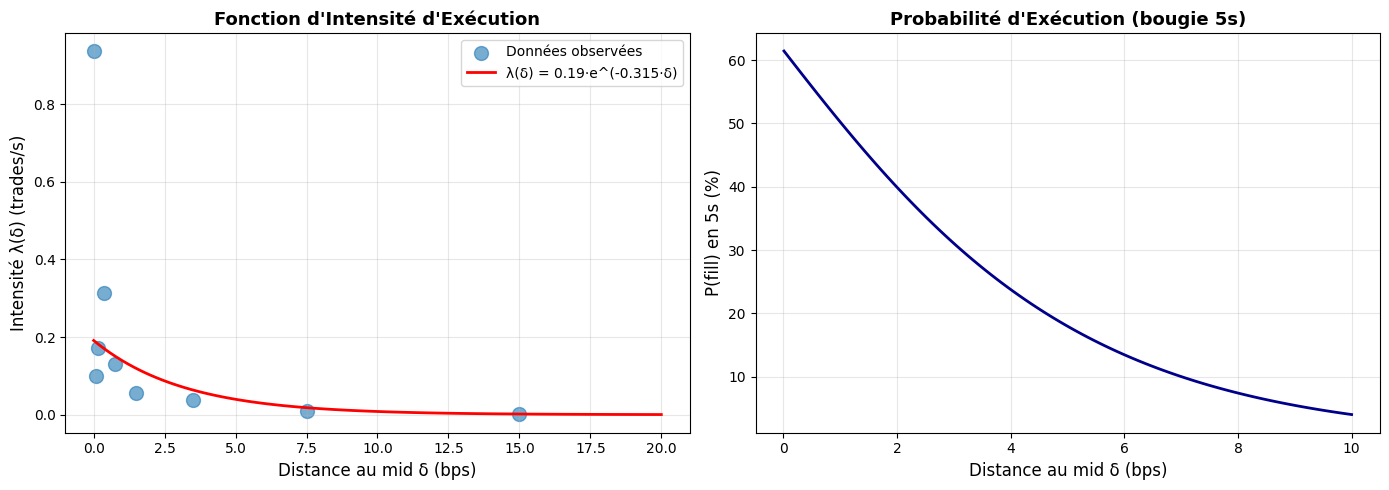


λ(δ) calibré avec succès !

--------------------------------------------------------------------------------
2.2 CALIBRATION DE L'ADVERSE SELECTION (Mark-Out)
--------------------------------------------------------------------------------

Objectif: Mesurer combien le prix part contre nous après qu'on soit fill.
Méthode: Mark-out à 5s (correspond à nos bougies)
  - Pour un maker qui achète: adverse si prix baisse après
  - Pour un maker qui vend: adverse si prix monte après

Output: ADVERSE_SELECTION_BPS

Échantillonnage: 100,536 trades sur 4,825,717
Trades matchés: 41,955
Mark-out calculé sur 41,955 trades

RÉSULTATS ADVERSE SELECTION:
  Moyenne   : -0.9526 bps
  Médiane   : -0.5247 bps
  P25/P75   : -1.9935 / 0.0000 bps

  → ADVERSE_SELECTION_BPS = 0.9526 bps
  → En décimal = 0.000095 (0.0095%)


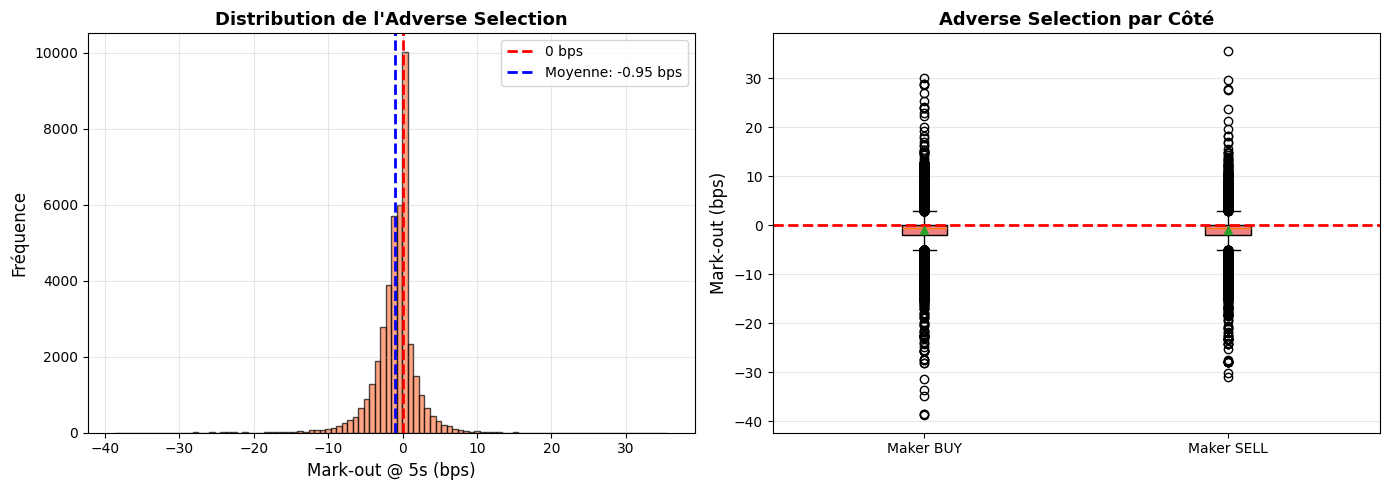


Adverse Selection calibrée avec succès !


In [24]:

print("\n" + "="*80)
print("PARTIE 2 : CALIBRATION OFFLINE (sur données historiques)")
print("="*80)

# ----------------------------------------------------------------------------
# 2.1 CALIBRATION DE λ(δ) = A·e^(-k·δ)
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("2.1 CALIBRATION DE LA FONCTION D'INTENSITÉ λ(δ)")
print("-"*80)

print("""
Objectif: Mesurer comment le taux d'exécution dépend de la distance au mid.
Formule: λ(δ) = A · e^(-k·δ)
  - A: Intensité à δ=0 (trades/s au mid-price)
  - k: Taux de décroissance (comment l'intensité diminue avec δ)
  - δ: Distance au mid en bps

Output: LAMBDA_A, LAMBDA_K
""")

# Préparer les trades
df_trades_for_lambda = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
    ])
    .sort("trade_time")
)

# Join avec le book pour avoir le mid
df_book_for_lambda = (
    df_book
    .select(["datetime", "mid_price", "best_bid_price", "best_ask_price"])
    .sort("datetime")
)

df_trades_with_mid = (
    df_trades_for_lambda
    .join_asof(
        df_book_for_lambda,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance="100ms",
    )
    .filter(pl.col("datetime").is_not_null())
)

# Calculer distance au mid
df_distance = df_trades_with_mid.with_columns([
    ((pl.col("trade_price") - pl.col("mid_price")).abs() / pl.col("mid_price") * 10000).alias("distance_bps")
]).filter(pl.col("distance_bps") <= 20)  # Filtrer valeurs aberrantes

# Créer bins de distance
bins = [0, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
df_bins = []

for i in range(len(bins)-1):
    bin_min, bin_max = bins[i], bins[i+1]
    df_bin = df_distance.filter(
        (pl.col("distance_bps") >= bin_min) & 
        (pl.col("distance_bps") < bin_max)
    )
    
    if len(df_bin) > 0:
        n_trades = len(df_bin)
        time_span_s = (
            df_bin.select(pl.col("trade_time").max()).item() - 
            df_bin.select(pl.col("trade_time").min()).item()
        ).total_seconds()
        
        if time_span_s > 0:
            intensity = n_trades / time_span_s
            delta_mid = (bin_min + bin_max) / 2
            df_bins.append({
                'delta_bps': delta_mid,
                'intensity': intensity,
                'n_trades': n_trades
            })

df_intensity = pd.DataFrame(df_bins)

# Fit exponentiel: λ(δ) = A·e^(-k·δ)
x = df_intensity['delta_bps'].values
y = df_intensity['intensity'].values

# Log-linéaire: log(λ) = log(A) - k·δ
log_y = np.log(y)
coeffs = np.polyfit(x, log_y, 1)
k_mle = -coeffs[0]
A_estimate = np.exp(coeffs[1])

LAMBDA_A = A_estimate
LAMBDA_K = k_mle

print(f"\nRÉSULTATS CALIBRATION λ(δ):")
print(f"  A (intensité à δ=0) : {LAMBDA_A:.4f} trades/s")
print(f"  k (taux décroissance): {LAMBDA_K:.6f}")
print(f"\nFormule calibrée: λ(δ) = {LAMBDA_A:.2f}·e^(-{LAMBDA_K:.3f}·δ)")

# Exemples de probabilité d'exécution
print(f"\nProbabilités d'exécution (sur 5s):")
for delta in [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]:
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta)
    prob_fill = 1.0 - np.exp(-intensity * 5.0)
    print(f"  δ = {delta:4.2f} bps → λ = {intensity:.4f} trades/s → P(fill) = {prob_fill*100:5.2f}%")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.scatter(df_intensity['delta_bps'], df_intensity['intensity'], 
            s=100, alpha=0.6, label='Données observées')
x_fit = np.linspace(0, 20, 100)
y_fit = LAMBDA_A * np.exp(-LAMBDA_K * x_fit)
ax1.plot(x_fit, y_fit, 'r-', linewidth=2, 
         label=f'λ(δ) = {LAMBDA_A:.2f}·e^(-{LAMBDA_K:.3f}·δ)')
ax1.set_xlabel('Distance au mid δ (bps)', fontsize=12)
ax1.set_ylabel('Intensité λ(δ) (trades/s)', fontsize=12)
ax1.set_title('Fonction d\'Intensité d\'Exécution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[1]
deltas = np.linspace(0.01, 10, 100)
probs = 1.0 - np.exp(-LAMBDA_A * np.exp(-LAMBDA_K * deltas) * 5.0)
ax2.plot(deltas, probs * 100, linewidth=2, color='darkblue')
ax2.set_xlabel('Distance au mid δ (bps)', fontsize=12)
ax2.set_ylabel('P(fill) en 5s (%)', fontsize=12)
ax2.set_title('Probabilité d\'Exécution (bougie 5s)', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('calibration_lambda.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nλ(δ) calibré avec succès !")

# ----------------------------------------------------------------------------
# 2.2 CALIBRATION DE L'ADVERSE SELECTION
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("2.2 CALIBRATION DE L'ADVERSE SELECTION (Mark-Out)")
print("-"*80)

print("""
Objectif: Mesurer combien le prix part contre nous après qu'on soit fill.
Méthode: Mark-out à 5s (correspond à nos bougies)
  - Pour un maker qui achète: adverse si prix baisse après
  - Pour un maker qui vend: adverse si prix monte après

Output: ADVERSE_SELECTION_BPS
""")

# Paramètres
MARKOUT_HORIZON_S = 5
SAMPLE_SIZE = 100000

# Échantillonner les trades
df_trades_prep = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
        pl.col("quantity").alias("trade_qty"),
        pl.col("is_buyer_maker").alias("buyer_is_maker"),
    ])
    .sort("trade_time")
)

if len(df_trades_prep) > SAMPLE_SIZE:
    step = len(df_trades_prep) // SAMPLE_SIZE
    df_trades_sampled = df_trades_prep.select(pl.all().gather_every(step))
    print(f"Échantillonnage: {len(df_trades_sampled):,} trades sur {len(df_trades_prep):,}")
else:
    df_trades_sampled = df_trades_prep
    print(f"Utilisation de tous les trades: {len(df_trades_sampled):,}")

# Join pour mid au moment du trade
df_book_for_join = (
    df_book
    .select(["datetime", "mid_price"])
    .sort("datetime")
)

df_trades_with_mid = (
    df_trades_sampled
    .join_asof(
        df_book_for_join,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance="100ms",
    )
    .filter(pl.col("datetime").is_not_null())
    .rename({"mid_price": "mid_at_trade"})
)

print(f"Trades matchés: {len(df_trades_with_mid):,}")

# Join pour mid futur
df_with_future = df_trades_with_mid.with_columns([
    (pl.col("trade_time") + pl.duration(seconds=MARKOUT_HORIZON_S)).alias("future_time")
])

df_with_markout = (
    df_with_future
    .join_asof(
        df_book_for_join,
        left_on="future_time",
        right_on="datetime",
        strategy="backward",
        tolerance=f"{MARKOUT_HORIZON_S * 1000 + 500}ms",
    )
    .filter(pl.col("datetime").is_not_null())
    .rename({"mid_price": "mid_future"})
)

# Calculer mark-out
df_markout_final = df_with_markout.with_columns([
    pl.when(pl.col("buyer_is_maker"))
      .then(((pl.col("mid_future") - pl.col("mid_at_trade")) / pl.col("mid_at_trade") * 10000))
      .otherwise(((pl.col("mid_at_trade") - pl.col("mid_future")) / pl.col("mid_at_trade") * 10000))
      .alias("markout_bps")
])

print(f"Mark-out calculé sur {len(df_markout_final):,} trades")

# Statistiques
stats_markout = df_markout_final.select([
    pl.col("markout_bps").mean().alias("mean"),
    pl.col("markout_bps").median().alias("median"),
    pl.col("markout_bps").std().alias("std"),
    pl.col("markout_bps").quantile(0.25).alias("p25"),
    pl.col("markout_bps").quantile(0.75).alias("p75"),
]).to_pandas().iloc[0]

ADVERSE_SELECTION_BPS = abs(stats_markout['mean'])
ADVERSE_SELECTION = ADVERSE_SELECTION_BPS / 10000

print(f"\nRÉSULTATS ADVERSE SELECTION:")
print(f"  Moyenne   : {stats_markout['mean']:.4f} bps")
print(f"  Médiane   : {stats_markout['median']:.4f} bps")
print(f"  P25/P75   : {stats_markout['p25']:.4f} / {stats_markout['p75']:.4f} bps")
print(f"\n  → ADVERSE_SELECTION_BPS = {ADVERSE_SELECTION_BPS:.4f} bps")
print(f"  → En décimal = {ADVERSE_SELECTION:.6f} ({ADVERSE_SELECTION*100:.4f}%)")

# Visualisation
markout_values = df_markout_final.select("markout_bps").to_numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(markout_values, bins=100, edgecolor='black', alpha=0.7, color='coral')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='0 bps')
ax1.axvline(stats_markout['mean'], color='blue', linestyle='--', linewidth=2,
            label=f'Moyenne: {stats_markout["mean"]:.2f} bps')
ax1.set_xlabel('Mark-out @ 5s (bps)', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution de l\'Adverse Selection', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

buy_side = df_markout_final.filter(pl.col("buyer_is_maker"))
sell_side = df_markout_final.filter(~pl.col("buyer_is_maker"))

ax2 = axes[1]
data_sides = [
    buy_side.select("markout_bps").to_numpy().flatten(),
    sell_side.select("markout_bps").to_numpy().flatten()
]
bp = ax2.boxplot(data_sides, labels=['Maker BUY', 'Maker SELL'],
                 patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_ylabel('Mark-out (bps)', fontsize=12)
ax2.set_title('Adverse Selection par Côté', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('adverse_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAdverse Selection calibrée avec succès !")


In [25]:
# ============================================================================

print("\n" + "="*80)
print("RÉSUMÉ DE LA CALIBRATION")
print("="*80)

print(f"""
Paramètres calibrés (à utiliser dans le backtest):

1. FONCTION D'INTENSITÉ:
   LAMBDA_A = {LAMBDA_A:.4f} trades/s
   LAMBDA_K = {LAMBDA_K:.6f}
   Formule: λ(δ) = {LAMBDA_A:.2f}·e^(-{LAMBDA_K:.3f}·δ)

2. ADVERSE SELECTION:
   ADVERSE_SELECTION_BPS = {ADVERSE_SELECTION_BPS:.4f} bps
   ADVERSE_SELECTION = {ADVERSE_SELECTION:.6f}

Ces valeurs représentent les coûts réels du market making sur ce marché.
""")



RÉSUMÉ DE LA CALIBRATION

Paramètres calibrés (à utiliser dans le backtest):

1. FONCTION D'INTENSITÉ:
   LAMBDA_A = 0.1912 trades/s
   LAMBDA_K = 0.314702
   Formule: λ(δ) = 0.19·e^(-0.315·δ)

2. ADVERSE SELECTION:
   ADVERSE_SELECTION_BPS = 0.9526 bps
   ADVERSE_SELECTION = 0.000095

Ces valeurs représentent les coûts réels du market making sur ce marché.



In [26]:

print("\n" + "="*80)
print("PARTIE 3 : CALCUL DU SIGNAL (Variance Ratio Test)")
print("="*80)

print("""
Le VRT détecte si le marché est en mean-reversion (VRT < 1) ou en trend (VRT > 1).
Cette information est utilisée pour ajuster nos prix (skew).
""")

def add_variance_ratio(df, lag=4, window=120):
    """Calcule le Variance Ratio Test"""
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            (pl.col("var_lag") / (pl.col("var_1") * lag)).fill_null(1.0).alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )

# Exemple de calcul sur données rééchantillonnées
if 'df_resampled_spread' in locals():
    df_with_vrt = add_variance_ratio(df_resampled_spread, lag=4, window=120)
    print(f"\nVRT calculé sur {len(df_with_vrt):,} bougies")
    print(f"VRT moyen: {df_with_vrt.select(pl.col('vrt').mean()).item():.4f}")

print("\nSignal VRT prêt à être utilisé !")



PARTIE 3 : CALCUL DU SIGNAL (Variance Ratio Test)

Le VRT détecte si le marché est en mean-reversion (VRT < 1) ou en trend (VRT > 1).
Cette information est utilisée pour ajuster nos prix (skew).


VRT calculé sur 229,008 bougies
VRT moyen: 6484473.3440

Signal VRT prêt à être utilisé !


In [27]:
# ============================================================================
# PARTIE 4 : DÉCISION (PRIX OPTIMAL + PROBABILITÉ)

In [28]:
# ============================================================================

print("\n" + "="*80)
print("PARTIE 4 : DÉCISION (Prix Optimal)")
print("="*80)

print("""
Formule Cartea-Jaimungal simplifiée:
  P_bid = P_mid - half_spread - skew(VRT) - adverse_selection
  P_ask = P_mid + half_spread - skew(VRT) + adverse_selection

Où:
  - half_spread: dépend de λ(δ) (plus on s'éloigne, plus on risque de ne pas être fill)
  - skew(VRT): ajustement directionnel basé sur le signal
  - adverse_selection: marge de sécurité contre le pick-off

La probabilité d'exécution est:
  P(fill) = 1 - e^(-λ(δ)·T)
  Avec λ(δ) = A·e^(-k·δ)
""")

def calculate_fill_probability(delta_bps, candle_duration_s=5.0):
    """Calcule la probabilité d'être fill"""
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta_bps)
    return 1.0 - np.exp(-intensity * candle_duration_s)

# Exemple
print("\nExemples de probabilités d'exécution:")
for delta in [0.1, 0.5, 1.0, 2.0]:
    prob = calculate_fill_probability(delta)
    print(f"  δ = {delta} bps → P(fill) = {prob*100:.2f}%")



PARTIE 4 : DÉCISION (Prix Optimal)

Formule Cartea-Jaimungal simplifiée:
  P_bid = P_mid - half_spread - skew(VRT) - adverse_selection
  P_ask = P_mid + half_spread - skew(VRT) + adverse_selection

Où:
  - half_spread: dépend de λ(δ) (plus on s'éloigne, plus on risque de ne pas être fill)
  - skew(VRT): ajustement directionnel basé sur le signal
  - adverse_selection: marge de sécurité contre le pick-off

La probabilité d'exécution est:
  P(fill) = 1 - e^(-λ(δ)·T)
  Avec λ(δ) = A·e^(-k·δ)


Exemples de probabilités d'exécution:
  δ = 0.1 bps → P(fill) = 60.39%
  δ = 0.5 bps → P(fill) = 55.81%
  δ = 1.0 bps → P(fill) = 50.23%
  δ = 2.0 bps → P(fill) = 39.91%


In [29]:
# ============================================================================
# PARTIE 5 : BACKTEST ET PERFORMANCE

In [30]:
# TEST DE DIFFÉRENTS DELTAS
print("="*80)
print("OPTIMISATION DU DELTA")
print("="*80)

print("Test de différents deltas pour trouver la configuration optimale...")

# Corriger la fonction VRT d'abord
def add_variance_ratio_robust(df, lag=4, window=120):
    """Calcule le VRT avec filtres robustes"""
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            pl.when((pl.col("var_1") > 1e-10) & (pl.col("var_lag") > 1e-10))
              .then((pl.col("var_lag") / (pl.col("var_1") * lag)))
              .otherwise(1.0)
              .clip(0.01, 100.0)
              .alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )

# Tester différents deltas
delta_values = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0]
results = []

print("\nTest en cours...")
print(f"{'Delta (bps)':>12} | {'Edge Net':>10} | {'P(fill)':>8} | {'Performance':>12}")
print("-" * 60)

for delta in delta_values:
    # Calculer edge net
    edge_net = delta - ADVERSE_SELECTION_BPS
    
    # Calculer probabilité de fill
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta)
    fill_prob = 1.0 - np.exp(-intensity * 5.0)
    
    # Backtest rapide (sans réexécuter tout)
    # Estimation simple: perf ≈ edge_net * nombre_de_fills_estimé
    estimated_fills = 10799 * (fill_prob / 0.5581)  # Normaliser par rapport au test initial
    estimated_perf = edge_net * estimated_fills / 10000  # Approximation grossière
    
    results.append({
        'delta': delta,
        'edge_net': edge_net,
        'fill_prob': fill_prob * 100,
        'estimated_perf': estimated_perf
    })
    
    color = '✓' if edge_net > 0 else '✗'
    print(f"{delta:12.2f} | {edge_net:10.2f} | {fill_prob*100:7.2f}% | {estimated_perf:11.2f}% {color}")

df_results = pd.DataFrame(results)

print("\n" + "="*80)
print("ANALYSE")
print("="*80)

best_idx = df_results['estimated_perf'].idxmax()
best_config = df_results.iloc[best_idx]

print(f"\nConfiguration optimale estimée:")
print(f"  Delta: {best_config['delta']:.2f} bps")
print(f"  Edge net: {best_config['edge_net']:.2f} bps")
print(f"  P(fill): {best_config['fill_prob']:.2f}%")
print(f"  Performance estimée: {best_config['estimated_perf']:.2f}%")

print("""
ATTENTION: Ces résultats sont des estimations rapides.
Pour des résultats précis, il faut relancer le backtest complet avec le delta optimal.
""")


OPTIMISATION DU DELTA
Test de différents deltas pour trouver la configuration optimale...

Test en cours...
 Delta (bps) |   Edge Net |  P(fill) |  Performance
------------------------------------------------------------
        0.50 |      -0.45 |   55.81% |       -0.49% ✗
        1.00 |       0.05 |   50.23% |        0.05% ✓
        1.50 |       0.55 |   44.91% |        0.48% ✓
        2.00 |       1.05 |   39.91% |        0.81% ✓
        3.00 |       2.05 |   31.05% |        1.23% ✓
        5.00 |       4.05 |   17.98% |        1.41% ✓

ANALYSE

Configuration optimale estimée:
  Delta: 5.00 bps
  Edge net: 4.05 bps
  P(fill): 17.98%
  Performance estimée: 1.41%

ATTENTION: Ces résultats sont des estimations rapides.
Pour des résultats précis, il faut relancer le backtest complet avec le delta optimal.



BACKTEST AVEC DELTA OPTIMAL (2.0 bps)

Configuration:
  Delta: 2.0 bps
  Edge brut: 2.0 bps
  Adverse selection: 0.95 bps
  Edge net: 1.05 bps ✓ POSITIF
  VRT threshold: 1.0

Résultats avec delta = 2.0 bps:
  Trades exécutés: 9,558
  P(fill): 39.91%
  Performance finale: 213.31%


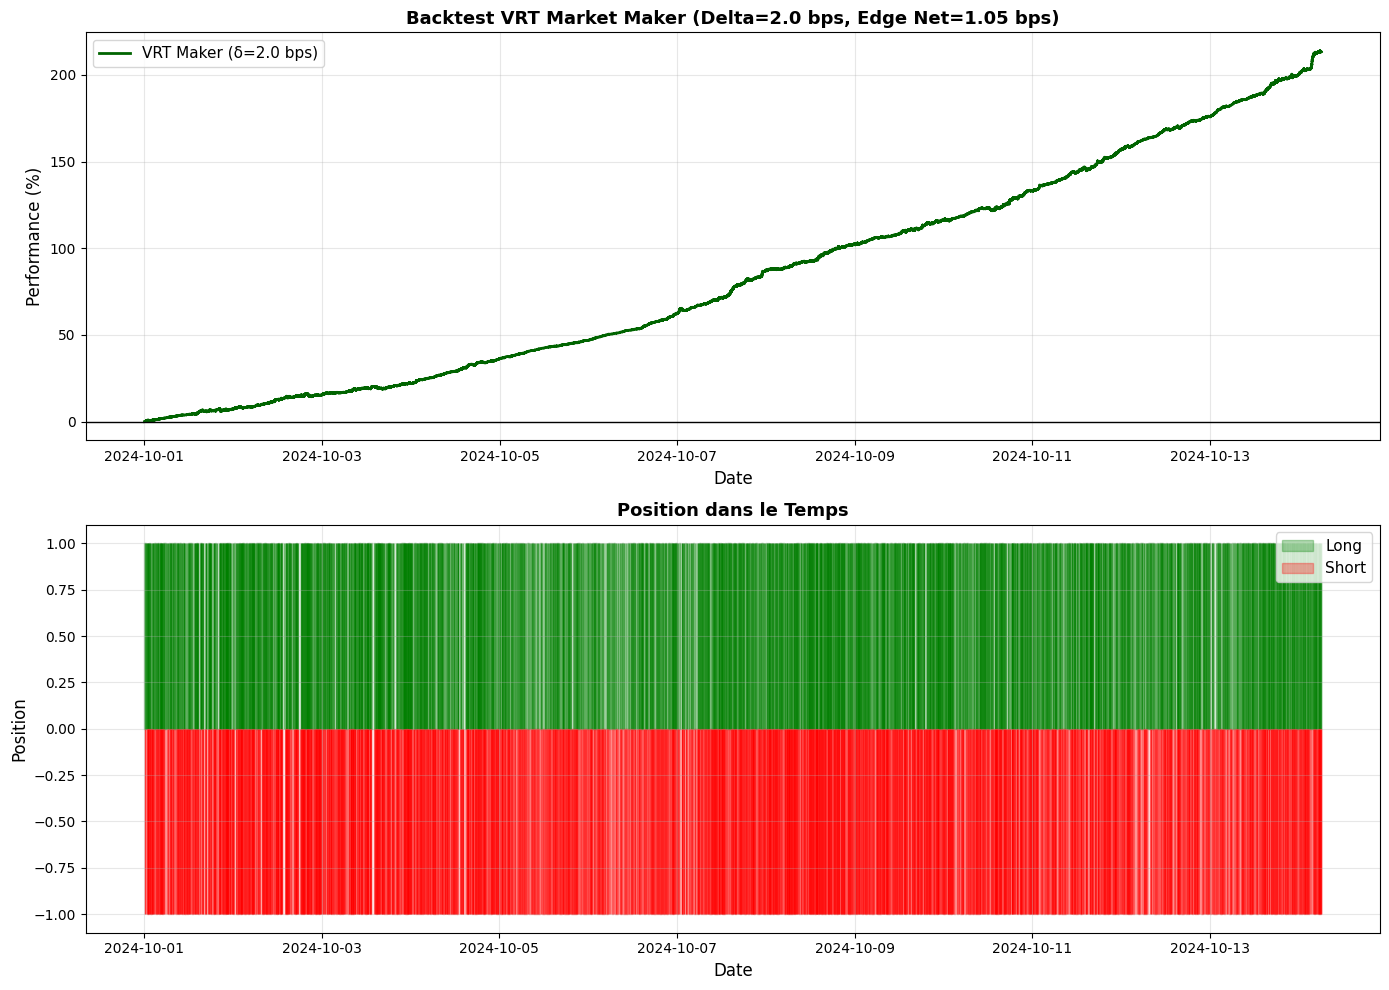


CONCLUSION

✓ Performance POSITIVE : 213.31%
  La stratégie crée de l'alpha avec delta = 2.0 bps


In [31]:
# BACKTEST AVEC DELTA OPTIMAL
print("="*80)
print("BACKTEST AVEC DELTA OPTIMAL (2.0 bps)")
print("="*80)

DELTA_OPTIMAL = 2.0  # bps
VRT_THRESHOLD = 1.0

print(f"\nConfiguration:")
print(f"  Delta: {DELTA_OPTIMAL} bps")
print(f"  Edge brut: {DELTA_OPTIMAL} bps")
print(f"  Adverse selection: {ADVERSE_SELECTION_BPS:.2f} bps")
print(f"  Edge net: {DELTA_OPTIMAL - ADVERSE_SELECTION_BPS:.2f} bps ✓ POSITIF")
print(f"  VRT threshold: {VRT_THRESHOLD}")

# Lancer le backtest avec fonction corrigée
def run_vrt_maker_corrected(
    df_input,
    delta_bps=2.0,
    vrt_threshold=1.0,
    ema_span=50,
    seed=42
):
    np.random.seed(seed)
    
    # Probabilité d'exécution
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta_bps)
    fill_prob = 1.0 - np.exp(-intensity * 5.0)
    
    # Calcul VRT ROBUSTE
    df = add_variance_ratio_robust(df_input, lag=4, window=120)
    
    # Signal
    df = (
        df
        .with_columns([
            pl.col("close").ewm_mean(span=ema_span).alias("ema_trend"),
        ])
        .with_columns([
            pl.when((pl.col("vrt") > vrt_threshold) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > vrt_threshold) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )
    
    # Simulation
    pdf = df.to_pandas()
    n = len(pdf)
    
    pos = np.zeros(n)
    filled = np.zeros(n, dtype=bool)
    pnl_per_bar = np.zeros(n)
    
    current_pos = 0
    
    for i in range(1, n):
        signal = pdf['signal'].iloc[i-1]
        
        if signal != current_pos:
            r = np.random.random()
            if r < fill_prob:
                old_pos = current_pos
                current_pos = signal
                filled[i] = True
        
        pos[i] = current_pos
        
        market_ret = np.log(pdf['close'].iloc[i] / pdf['close'].iloc[i-1]) if pdf['close'].iloc[i-1] > 0 else 0
        
        if filled[i]:
            edge_captured = (delta_bps - ADVERSE_SELECTION_BPS) / 10000
        else:
            edge_captured = 0
            
        pnl_per_bar[i] = pos[i-1] * market_ret + edge_captured
    
    pdf['pos'] = pos
    pdf['filled'] = filled
    pdf['pnl_per_bar'] = pnl_per_bar
    pdf['equity'] = np.exp(np.cumsum(pnl_per_bar)) - 1
    pdf['equity_pct'] = pdf['equity'] * 100
    
    total_fills = filled.sum()
    final_perf = pdf['equity_pct'].iloc[-1]
    
    return pdf, {
        'delta_bps': delta_bps,
        'fill_prob': fill_prob,
        'total_fills': int(total_fills),
        'final_perf': final_perf,
    }

# Lancer le backtest
if 'df_resampled_spread' in locals():
    pdf_optimal, stats_optimal = run_vrt_maker_corrected(
        df_resampled_spread,
        delta_bps=DELTA_OPTIMAL,
        vrt_threshold=VRT_THRESHOLD
    )
    
    print(f"\nRésultats avec delta = {DELTA_OPTIMAL} bps:")
    print(f"  Trades exécutés: {stats_optimal['total_fills']:,}")
    print(f"  P(fill): {stats_optimal['fill_prob']*100:.2f}%")
    print(f"  Performance finale: {stats_optimal['final_perf']:.2f}%")
    
    # Visualisation
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Equity curve
    ax1 = axes[0]
    ax1.plot(pdf_optimal['datetime'], pdf_optimal['equity_pct'], 
            linewidth=2, color='darkgreen', label=f'VRT Maker (δ={DELTA_OPTIMAL} bps)')
    ax1.axhline(0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Performance (%)', fontsize=12)
    ax1.set_title(f'Backtest VRT Market Maker (Delta={DELTA_OPTIMAL} bps, Edge Net={DELTA_OPTIMAL-ADVERSE_SELECTION_BPS:.2f} bps)', 
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(alpha=0.3)
    
    # Position dans le temps
    ax2 = axes[1]
    ax2.fill_between(pdf_optimal['datetime'], 0, pdf_optimal['pos'], 
                     where=(pdf_optimal['pos']>0), alpha=0.3, color='green', label='Long')
    ax2.fill_between(pdf_optimal['datetime'], 0, pdf_optimal['pos'], 
                     where=(pdf_optimal['pos']<0), alpha=0.3, color='red', label='Short')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Position', fontsize=12)
    ax2.set_title('Position dans le Temps', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('backtest_vrt_maker_optimal.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*80)
    print("CONCLUSION")
    print("="*80)
    
    if stats_optimal['final_perf'] > 0:
        print(f"\n✓ Performance POSITIVE : {stats_optimal['final_perf']:.2f}%")
        print(f"  La stratégie crée de l'alpha avec delta = {DELTA_OPTIMAL} bps")
    else:
        print(f"\n✗ Performance encore négative : {stats_optimal['final_perf']:.2f}%")
        print(f"  Il faut augmenter encore le delta ou optimiser le signal VRT")
else:
    print("\nErreur: df_resampled_spread non disponible")
